In [11]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from tools.helper import clean_str
import time

In [2]:
DATA_PATHS = ['/data/2016_sic/ioannis_data/new_data_3/fold0/training.json',
              '/data/2016_sic/ioannis_data/new_data_3/fold0/training.json',
             ]
data = []
for DATA_PATH in DATA_PATHS:
    with open(DATA_PATH) as json_file:  
        for line in json_file:
            data.append(json.loads(line))

In [3]:
df = pd.DataFrame(data)
df.head()

,class,des,des_class,web,web_class,web_id
0,contradiction,loading and unloading of goods or passengers ...,52241,DVB Bank - Homepage,64929,216475
1,contradiction,manufacture of luggage handbags and the like ...,15120,Independent financial advisors in Lancashire f...,66190,82098
2,entailment,repair of fishing nets including mending repa...,33190,Welcome to A1 Lifts. Professional and reliable...,33190,453844
3,contradiction,preparation and serving of beverages for imme...,56302,Largest choice of tiles in the South West. We ...,46730,690360
4,contradiction,manufacture of felt manufacture of tulles and...,13990,"Leading UK pharmacy services, products, prescr...",47730,337516


In [4]:
df = df[df['class']=='entailment']
df = df.drop(columns = ['class', 'des', 'des_class'])
df = df.drop_duplicates()
df = df.rename(columns = {'web_id':'id','web':'text','web_class':'categories'})
df = df.set_index('id')

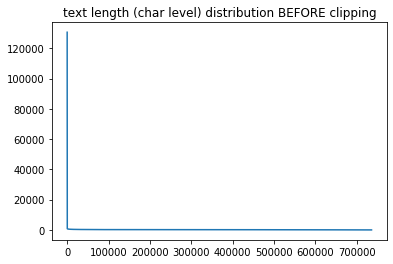

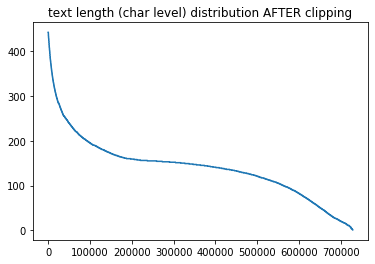

In [5]:
# text length (char level)
tt = df['text'].apply(len)
plt.plot(sorted(tt.values,reverse= True))
plt.title('text length (char level) distribution BEFORE clipping')
plt.show()
q = np.percentile(tt.values,99)
plt.plot(sorted([t for t in tt.values if t<=q],reverse= True))
plt.title('text length (char level) distribution AFTER clipping')
plt.show()

In [6]:
# clip 
def clip_this(s,q):
    if len(s)<=q:
        return s
    ind = s[:q].rfind(' ')
    return s[:ind]
df['text'] = df['text'].apply(lambda x:clip_this(x,int(q)))

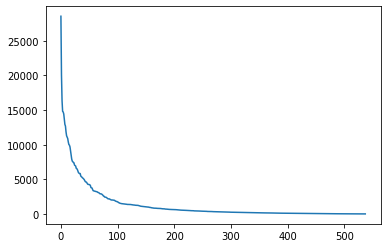

In [7]:
# class distribution
plt.title('class distribution')
plt.plot(sorted(df.categories.value_counts().values,reverse = True))
plt.show()

In [8]:
df.head()

,text,catergories
id,,
453844,Welcome to A1 Lifts. Professional and reliable...,33190
914843,"Our friendly service, surprising range of fres...",47110
326959,"Wherever you want to get to in life, Lloyds Ba...",64191
541943,Stanley Gibbons – The home of stamp collecting...,47789
445157,Are you looking for high-quality dentistry in ...,86230


In [9]:
cleaned = {}

In [55]:
# clean text
aa = len(df)
start = time.time()
for i,(id,text) in enumerate(df['text'].iteritems()):
    if id in cleaned.keys():
        continue
    cleaned[id] = clean_str(text)
    if i%(aa//10)==0:
        duration = time.time()-start
        print('{:02d}:{:02d}'.format(int(duration//60),int(duration%60)))
        print('COMPLETE {:.0f}% '.format(i/aa*100),end = '')
    elif i%(aa//100)==0:
        print('.',end = '')

In [15]:
df['text'] = df.index.map(cleaned)

# test train split

In [25]:
test_split = 0.2
split = int(len(df)*test_split)
ind = np.arange(len(df))
np.random.seed(0)
np.random.shuffle(ind)

In [40]:
df['train/test']='train'
df.loc[df.index.values[ind[:split]],'train/test']='test'

In [41]:
df['train/test'].value_counts()

train    588992
test     147247
Name: train/test, dtype: int64

In [48]:
df.head()

,text,categories,train/test
id,,,
453844,welcome to a1 lifts . professional and reliabl...,33190,train
914843,"our friendly service , surprising range of fre...",47110,train
326959,"wherever you want to get to in life , lloyds b...",64191,train
541943,stanley gibbons – the home of stamp collecting...,47789,train
445157,are you looking for high-quality dentistry in ...,86230,train


In [47]:
df.to_pickle('data/sic.pkl')

# for FastText

In [49]:
df['joined'] = df.apply(lambda x: '__label__' + x['categories'].strip()+' '+x['text'].strip(),axis=1)

In [50]:
df.head()

,text,categories,train/test,joined
id,,,,
453844,welcome to a1 lifts . professional and reliabl...,33190,train,__label__33190 welcome to a1 lifts . professio...
914843,"our friendly service , surprising range of fre...",47110,train,"__label__47110 our friendly service , surprisi..."
326959,"wherever you want to get to in life , lloyds b...",64191,train,__label__64191 wherever you want to get to in ...
541943,stanley gibbons – the home of stamp collecting...,47789,train,__label__47789 stanley gibbons – the home of s...
445157,are you looking for high-quality dentistry in ...,86230,train,__label__86230 are you looking for high-qualit...


In [54]:
np.savetxt('data/FT/sic.test.txt',df[df['train/test']=='test'].joined.values,fmt='%s')
np.savetxt('data/FT/sic.train.txt',df[df['train/test']=='train'].joined.values,fmt='%s')

# some more stats

In [56]:
train_len = df[df['train/test']=='train']['text'].apply(lambda x:len(x.split(' '))).values

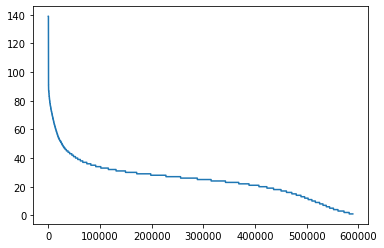

In [58]:
plt.plot(sorted(train_len,reverse = True))